# Working with Unlabeled Data - Clustering Analysis

In the previous chapters, we used supervised learning techniques to build machine learning models using data where the answer was already known - the class labels were already available in our training data. In this chapter, we will switch gears and explore cluster analysis, a category of **unsupervised learning** techniques that allows us to discover hidden structures in data where we do not know the right answer upfront. The goal of clustering is to find a natural grouping in data so that items in the same cluster are more similar to each other than to those from different clusters. 

Given its exploratory nature, clustering is an exciting topic and, in this chapter, we will learn about the following concepts, which can help us to organize data into meaningful structures: 

* Finding centers of similarity using the popular k-means algorithms
* Taking a bottom-up approach to building hierarchical clustering trees
* Identifying arbitrary shapes of objects using a density-based clustering approach

# Grouping objects by similarity using k-means

In this section, we will learn about one of the most popular **clustering** algorithms, **k-means**, which is widely used in academia as well as in industry. Clustering (or cluster analysis) is a technique that allows us to find groups of similar objects, objects that are more related to each other than to objects in other groups. Examples of business-oriented applications of clustering include the grouping of documents, music, and movies by different topics, or finding customers that share similar interests based on common purchase behaviors as a basis for recommendation engines. 

## K-means clustering using scikit-learn

As we will see in a moment, the k-means algorithm is extremely easy to implement but is also computationally very efficient compared to other clustering algorithms, which might explain its popularity. The k-means algorithm belongs to the category of **prototype-based clustering**. We will discuss two other categories of clustering, **hierarchical** and **density-based clustering**, later in this chapter. 

Prototype-based clustering means that each cluster is represented by a prototype, which can either be the **centroid** (average) of similar points with continuous features, or the **medoid** (the most representative or most frequently occurring point) in the case of categorical features. While k-means is very good at identifying clusters with a spherical shape, one of the drawbacks of this clustering algorithm is that we have to specify the number of clusters, $k$, a priori. An inappropriate choice of $k$ can result in poor clustering performance. Later in this chapter, we will discuss the **elbow** method and **silhouett plots**, which are useful techniques to evaluate the quality of a clustering to help us determine the optimal number of clusters $k$. 

Although k-means clustering can be applied to data in higher dimensions, we will walk through the following examples using a simple two-dimensional dataset for the purpose of visualization:

In [1]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=150, 
                  n_features=2, 
                  centers=3, 
                  cluster_std=0.5, 
                  shuffle=True, 
                  random_state=0)

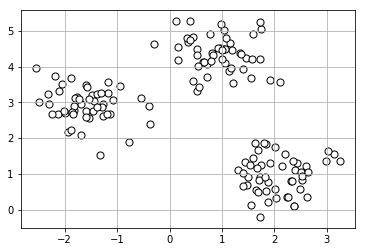

In [2]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c='white', 
            marker='o', edgecolor='black', s=50)
plt.grid()
plt.show()

The dataset that we just created consists of 150 randomly generated points that are roughly grouped into three regions with higher density, which is visualized via a two-dimensional scatterplot. 

In real-world applications of clustering, we do not have any groud truth category information (information provided as empirical evidence as opposed to inference) about those samples; otherwise, it would fall into category of supervised learning. Thus, our goal is to group the samples based on their feature similarities, which can be achieved using the k-means algorithm that can be summarized by the following four steps:

1. Randomly pick $k$ centroids from the sample points as initial cluster centers
2. Assign each sample to the nearest centroid $\mu^{(j)}, j \in \{1, \ldots, k\}$
3. Move the centroids to the center of the samples that were assigned to it. 
4. Repeat steps 2 and 3 until the cluster assignments do not change or a user-defined torelance or maximum number of iterations is reached. 

Now, the next question is *how do we measure similarity between objects?* We can define similirity as the opposite of the distance, and a commonly used distance for clustering samples with continuous features is the **squared Euclidean distance** between two points $x$ and $y$ in $m$-dimensional space:

$$d(x, y)^2 = \sum_{j=1}^m(x_j - y_j)^2 = ||(x-y)||_2^2$$

Note that, in the preceding equation, the index $j$ refers to the $j$th dimension (feature column) of the samples points $x$ and $y$. In the rest of this section, we will use the superscripts $i$ and $j$ to refer to the samples index and cluster index, respectively. 

Based on this Euclidean distance metric, we can describe the k-means algorithm as a simple optimization problem, an iterative approach for minimizing the within-cluster **Sum of squared Errors (SSE)**, which is sometimes also called **cluster inertia**:

$$SSE = \sum_{i=1}^n\sum_{j=1}^kw^{(i, j)}||x^{(i)} - \mu^{(j)}||_2^2$$

Here, $\mu^{(j)}$ is the representative point (centroid) for cluster $j$, and $w^{(i, j)} = 1$ if the sample $x^{(i)}$ is in cluster $j$; $w^{(i, j)} = 0$ otherwise. 

Now that we have learned how the simple $k$-means algorithm works, let's apply it to our sample dataset using the *KMeans* class from scikit-learn's *cluster* module:

In [3]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3, init='random', n_init=10, 
            max_iter=300, tol=1e-04, random_state=0)

y_km = km.fit_predict(X)

Using the preceding code, we set the number of desired clusters to 3; specifying the number of clusters *a priori* is one of the limitations of k-means. We set *n_init=10* to run the k-means clustering algorithm 10 times independently with different random centroids to choose the final model as the one with lowest SSE. Via the *max_iter* parameter, we specify the maximum number of iterations for each single run (here, 300). Note that the k-means implementation in scikit-learn stops early if it converges before the maximum number of iterations is reached. However, it is possible that k-means does not reach convergence for a particular run, which can be problematic (computationally expensive) if we choose relatively large values for *max_iter*. One way to deal with convergence problem is to choose larger values for *tol*, which is a parameter that controls the tolerance with regard to the changes in the within-cluster sum-squared-error to declared convergence. In the preceding code, we chose a tolerance of 0.0001. 

A problem with k-means is that one or more clusters can be empty. Note that this problem does not exist for k-medoids or fuzzy C-means, an algorithm that we will discuss later in this section. However, this problem is accounted for in the current k-means implementation in scikit-learn. If a cluster is empty, the algorithm will search for the sample that is farthest away from the centroid of the empty cluster. Then it will assign the centroid to be this farthest point. 

When we are applying k-means to real-world data using a Euclidean distance metric, we want to make sure that the features are measured on the same scale and apply z-score standardization or min-max scaling if necessary. 

After we predicted the cluster labels *y_km* and discussed some of the challenges of the k-means algorithm, let's now visualize the clusters that k-means identified in the data together with the cluster centroids. These are stored under the *cluster_centers_* attribute of the fitted *KMeans* object: 

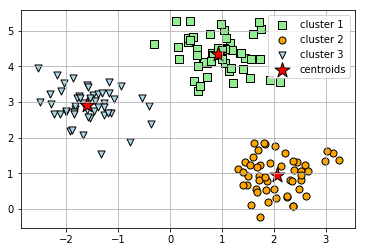

In [4]:
plt.scatter(X[y_km==0, 0], X[y_km==0, 1], 
            s=50, c='lightgreen', marker='s', 
            edgecolor='black', label='cluster 1')
plt.scatter(X[y_km==1, 0], X[y_km==1, 1], 
            s=50, c='orange', marker='o', 
            edgecolor='black', label='cluster 2')
plt.scatter(X[y_km==2, 0], X[y_km==2, 1], 
            s=50, c='lightblue', marker='v', 
            edgecolor='black', label='cluster 3')
plt.scatter(km.cluster_centers_[:, 0], 
            km.cluster_centers_[:, 1], 
            s=250, marker='*', c='red', 
            edgecolor='black', label='centroids')
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

In the resulting scatterplot, we can see that k-means placed the three centroids at the center of each sphere, which looks like a resonable grouping given this dataset.

Although k-means worked well on this toy dataset, we shall highlight another drawback of k-means: we have to specify the number of clusters, $k$, * a priori*. The number of clusters to choose may not always be so obvious in real-world applications, especially if we are working with higher dimensional dataset that cannot be visualized. The other properties of k-means are that clusters do not overlap and are not hierarchical, and we also assume that there is at least one item in each cluster. Later in this chapter, we will encounter different types of clustering algorithms, hierarchical and density-based clustering. Neither type of algorithm require us to specify the number of clusters upfront or assume spherical structures in our dataset. 

In the next subsection, we will introduce a popular variant of the classic k-means algorithm called **k-means++**. While it does not address those assumptions and drawbacks of k-means discussed in the previous paragraph, it can greatly improve the clustering results through more clever seeding of the initial cluster centers. 

## A smarter way of placing the initial cluster centroids using k-means++

So far, we have discussed the classic k-means algorithm that uses a random seed to place the initial centroids, which can sometimes result in bad clusterings or slow convergence if the initial centroids are chosen poorly. One way to address this issue is to run the k-means algorithm multiple times on a dataset and choose the best performing model in terms of the SSE. Another strategy is to place the initial centroids far away from each other via the k-means++ algorithm, which leads to better and more consistent results than the classic k-means. The initialization in k-means++ can be summarized as follows:

1. Initialize an empty set $M$ to store the $k$ centroids being selected.
2. Randomly choose the first centroid $\mu^{(j)}$ from the input samples and assign it to $M$.
3. For each sample $x^{(i)}$ that is not in $M$, find the minimum squared distance $d(x^{(i)}, M)^2$ to any of the centroids in $M$. 
4. To randomly select the next centroid $\mu{p}$, use a weighted probability distribution equal to $\frac{d(\mu^{(p)}, M)^2}{\sum_i d(x^{(i)}, M)^2}$.
5. Repeat steps 2 and 3 until $k$ centroids are chosen.
6. Proceed with the classic k-means algorithm. 

To use k-means++ with scikit-learn's *KMeans* object, we just need to set the *init* parameter to *'k-means++'*. In fact, *'k-means++'* is the default argument to the *init* parameter, which is strongly recommended in practice. The only reason we haven't used it in the previous example was to not introduce too many concepts all at once. The rest of this section on k-means will use k-means++, but readers are encouraged to experiment more with the two different approaches (classic k-means via *init='random'* versus k-means++ with *init='k-means++'*) for placing the initial cluster centroids. 

## Hard versus soft clustering

**Hard clustering** describes a family of algorithms where each sample in a dataset is assigned to exactly one cluster, as in the k-means algorithm that we discussed in the previous subsection. In contrast, algorithm for **soft clustering** (sometimes also called **fuzzy clustering**) assign a sample to one or more clusters. A popular example of soft clustering is the **fuzzy C-means (FCM)** algorithm (also called **soft k-means** or **fuzzy k-means**). 

The FCM procedure is very similar to k-means. However, we replace the hard cluster assignment with probabilities of each point belonging to each cluster. In k-means, we could express the cluster membership of sample $x$ with a sparse vector of binary values: 

$$\mu^{(1)} \rightarrow 0; \mu^{(2)} \rightarrow 1; \mu^{(2)} \rightarrow 0$$

Here, the index position with value 1 indicates that the cluster centroid $\mu^{(j)}$ the sample is assigned to (assuming $k=3, j \in \{1, 2, 3\}$). In contrast, a membership vector in FCM could be represented as follows:

$$\mu^{(1)} \rightarrow 0.10; \mu^{(2)} \rightarrow 0.85; \mu^{(2)} \rightarrow 0.05$$

Here, each value falls in the range $[0, 1]$ and represents a probability of membership of the respective cluster centroid. The sum of the memberships for a given sample is equal to 1. Similar to the k-means algorithm, we can summarize the FCM algorithm in four steps:

1. Specify the number of $k$ centroids and randomly assign the cluster memberships for each point.
2. Compute the cluster centroids $\mu^{(j)}, j \in \{1, \ldots, k\}$.
3. Update the cluster memberships for each point.
4. Repeat steps 2 and 3 until the membership coefficients do not change, or a user-defined tolerance or maximum number of iterations is reached.

The objective function of FCM - we abbreviate it as $J_m$ - looks very similar to the within cluster sum-squared-error that we minimize in k-means:

$$J_m = \sum_{i=1}^n\sum_{j=1}^k w^{m(i, j)} ||x^{(i)} - \mu^{(j)}||_2^2$$

However, note that the membership indicator $w^{(i, j)}$ is not a binary value as in k-means ($w^{(i, j)} \in \{0, 1\}$), but a real value that denotes that cluster membership probability ($w^{(i, j)} \in [0, 1]$). You also may have noticed that we added an additional exponent to $w^{(i, j)}$; the exponent $m$, any number greater than or equal to one (typically $m=2$), is the so-called **fuzziness coefficient** (or simply **fuzzfier**) that controls the degree of *fuzziness*. The larger the value of $m$ the smaller the cluster membership $w^{(i, j)}$ becomes, which leads to fuzzier clusters. The cluster membership probability itself is calculated as follows:

$$w^{(i, j)} = \left[\sum_{p=1}^k\left(\frac{||x^{(i)} - \mu^{(j)}||_2}{||x^{(i)} - \mu^{(p)}||_2}\right)^{\frac{2}{m-1}}\right]^{-1}$$

The center $\mu^{(j)}$ of a cluster itself is calculated as the mean of all samples weighted by the degree to which each sample belongs to that cluster ($$w^{m(i, j)}$$):

$$\mu^{(j)} = \frac{\sum_{i=1}^n w^{m(i, j)} x^{(i)}}{\sum_{i=1}^n w^{m(i, j)}}$$

Just by looking at the equation to calculate the cluster memberships, it is intuitive to say that each iteration in FCM is more expensive than an iteration in k-means. However, FCM typically requires fewer iterations overall to reach convergence. Unfortunately, the FCM algorithm is currently not implemented in scikit-learn. However, it has been found in practice that both k-means and FCM produce very similar clustering outputs.

## Using the elbow method to find the optimal number of clusters

One of the main challenges in unsupervised learning is that we do not know the definitive answer. We do not have the ground truth class labels in our dataset that allow us to apply the techniques that we used earlier, in order to evaluate the performance of a supervised model. Thus, to quantify the quality of clustering, we need to use intrinsic metrics - such as the within-cluster SSE (distortion) that we discussed earlier in this chapter - to compare the performance of different k-means clusterings. Conveniently, we do not need to compute the within-cluster SSE explicitly when we are using scikit-learn, as it is already accessible via the *inertia_* attribute after fitting a *KMeans* model:

In [5]:
print('Distortion: %.2f' % km.inertia_)

Distortion: 72.48


Based on the within-cluster SSE, we can use a graphical tool, the so-called **elbow method**, to estimate the optimal number of clusters $k$ for a given task. Intuitively, we can say that, if $k$ increases, the distortion will decrease. This is because the samples will be closer to the centroids they are assigned to. The idea behind the elbow method is to identify the value of $k$ where the distortion begins to increase most rapidly, which will become cleaner if we plot the distortion for different values of $k$: 

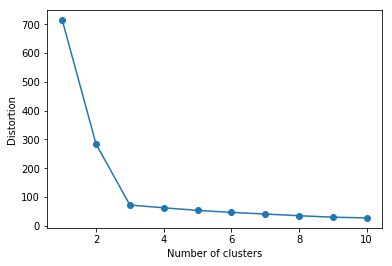

In [6]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, init='k-means++', 
                n_init=10, max_iter=300, random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)

plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

As we can see in the resulting plot, the *elbow* is located at $k=3$, which is evidence that $k=3$ is indeed a good choice for this dataset. 

## Quantifying the quality of clustering via silhouette plots

Another intrinsic metric to evaluate the quality of a clustering is **silhouette analysis**, which can also be applied to clustering algorithm other than k-means that we will discuss later in this chapter. Silhouette analysis can be used as a graphical tool to plot a measure of how tightly grouped the samples in the clusters are. To calculate the **silhouette coefficient** of a single sample in our dataset, we can apply the following three steps:

1. Calculate the **cluster cohesion** $a^{(i)}$ as the average distance between a sample $x^{(i)}$ and all other points in the same cluster. 
2. Calculate the **cluster separation** $b^{(i)}$ from the next closest cluster as the average distance between the sample $x^{(i)}$ and all samples in the nearest cluster.
3. Calculate the silhouette $s^{(i)}$ as the difference between cluster cohesion and separation divided by the greater of the two, as shown here:

$$s^{(i)} = \frac{b^{(i)}-a^{(i)}}{max\{b^{(t)}, a^{(t)}\}}$$

The silhouette coefficient is bounded in the range -1 to 1. Based on the preceding equation, we can see that the silhouette coefficient is 0 if the cluster separation and cohesion are equal. Furthermore, we get close to an ideal silhouette coefficient of 1 if the cluster separation is greater than cohesion, since the separation quantifies how dissimilar a sample is to other clusters, and cohesion tells us how similar it is to the other samples in its own cluster.

The silhouette coefficient is available as *silhouette_samples* from scikit-learn's *metric* module, and optionally, the *silhouette_scores* function can be imported for convenience. The *silhouette_scores* function calculates the average silhouette coefficient across all samples, which is equivalent to *numpy.mean(silhouette_samples(...))*. By executing the following code, we will now create a plot of the silhouette coefficients for a k-means clustering with $k=3$: 

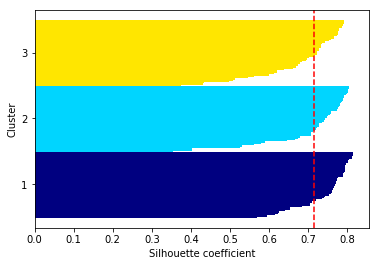

In [7]:
km = KMeans(n_clusters=3, init='k-means++', n_init=10, 
            max_iter=300, tol=1e-04, random_state=0)
y_km = km.fit_predict(X)

import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')

y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km==c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i)/n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), 
             c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color='red', linestyle='--')
plt.yticks(yticks, cluster_labels+1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()

Through a visual inspection of the silhouette plot, we can quickly scrutinize the sizes of the different clusters and identify clusters that contain *outliers*.

However, as we can see in the preceding silhouette plot, the silhouette coefficients are not even close to 0, which is in this case an indicator of a good clustering. Furthermore, to summarize the goodness of our clustering, we added the average silhouette coefficient to the plot (dotted line).

To see what a silhouette plot looks like for a relatively bad clustering, let's seed the k-means algorithm with only two centroids:

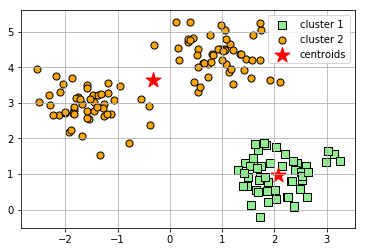

In [8]:
km = KMeans(n_clusters=2, init='k-means++', 
            n_init=10, max_iter=300, tol=1e-04, 
            random_state=0)
y_km = km.fit_predict(X)

plt.scatter(X[y_km==0,0], X[y_km==0, 1], 
            s=50, c='lightgreen', edgecolor='black', 
            marker='s', label='cluster 1')
plt.scatter(X[y_km==1,0], X[y_km==1, 1], 
            s=50, c='orange', edgecolor='black', 
            marker='o', label='cluster 2')
plt.scatter(km.cluster_centers_[:, 0], 
            km.cluster_centers_[:, 1], 
            s=250, c='red', marker='*', 
            label='centroids')
plt.legend()
plt.grid()
plt.show()

As we can see in the resulting plot, one of the centroids falls between two of the three spherical groupings of the sample points. Although the clustering does not look completely terrible, it is suboptimal. 

Please keep in mind that we typically do not have the luxury of visualizing datasets in two-dimensional scatterplots in real-world problems, since we typically work with data in higher dimensions. So, next, we create the silhouette plot to evaluate the results:

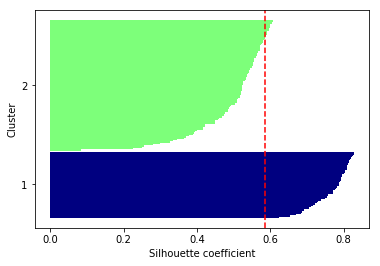

In [9]:
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')

y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km==c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i)/n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), 
             c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color='red', linestyle='--')
plt.yticks(yticks, cluster_labels+1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()

As we can see in the resulting plot, the silhouettes now have visibly different lengths and widths, which is a evidence for a relatively bad or at least suboptimal clustering. 

# Organizing clusters as a hierarchical tree

In ths section, we will take a look at an alternative approach to prototype-based clustering: **hierarchical clustering**. One advantage of hierarchical clustering algorithms is that it allows us to plot **dendrograms** (visualization of a binary hierarchical clustering), which can help with the interpretation of the results by creating meaningful taxonomies. Another useful advantage is this hierarchical approach is that we do not need to specify the number of clusters up front. 

The two main approaches to hierarchical clustering are **agglomerative** and **divisive** hierarchical clustering. In diviside hierarchical clustering, we start with one cluster that encompasses all our samples, and we iteratively split the cluster into smaller clusters until each cluster only contains one sample. In this section, we will focus on agglomerative clustering, which takes the opposite approach. We start with each sample as an individual cluster and merge the closest pairs of clusters until only one cluster remains. 

## Grouping clusters in bottom-up fashion

The two standard algorithms for agglomerative hierarchical clustering are **single linkage** and **complete linkage**. Using single linkage, we compute the distances between the most similar members for each pair of clusters and merge the two clusters for which the distance between the most similar members is the smallest. The complete linkage approach is similar to single linkage but, instead of comparing the most similar members in each pair of clusters, we compare the most dissimilar members to perform the merge. This is shown in the following diagram: 

<img src='images/11_07.png'>

Other commonly used algorithms for agglomerative hierarchical clustering include **average linkage** and **Ward's linkage**. In average linkage, we merge the cluster pairs based on the minimum average distances between all group members in the two clusters. In Ward's linkage, the two clusters that lead to the minimum increase of the total within-cluster SSE are merged. 

In this section, we will focus on agglomerative clustering using the complete linkage approach. Hierarchical complete linkage clustering is an iterative procedure that can be summarized by the following steps: 

1. Compute the distance matrix of all samples.
2. Represent each data point as a singleton cluster.
3. Merge the two closest clusters based on the distance between the most dissmilar (distant) members.
4. Update the similarity matrix.
5. Repeat steps 2-4 until one single cluster remains.

Next, we will discuss how to compute the distance matrix (step 1). But first, let's generate some random sample data to work with: the rows represent different observations (IDs 0-4), and the columns are the different features (*X, Y, Z*) of those samples: 

In [10]:
import pandas as pd
import numpy as np

np.random.seed(123)
variables = ['X', 'Y', 'Z']
labels = ['ID_0', 'ID_1', 'ID_2', 'ID_3', 'ID_4']
X = np.random.random_sample([5, 3])*10
df = pd.DataFrame(X, columns=variables, index=labels)
df

,X,Y,Z
ID_0,6.964692,2.861393,2.268515
ID_1,5.513148,7.194690,4.231065
ID_2,9.807642,6.848297,4.809319
ID_3,3.921175,3.431780,7.290497
ID_4,4.385722,0.596779,3.980443


## Performing hierarchical clustering on a distance matrix

To calculate the distance matrix as input for the hierarchical clustering algorithm, we will use the *pdist* function from SciPy's *spatial.distance* submodule:

In [11]:
from scipy.spatial.distance import pdist, squareform

row_dist = pd.DataFrame(squareform(pdist(df, metric='euclidean')), 
                        columns=labels, index=labels)
row_dist

,ID_0,ID_1,ID_2,ID_3,ID_4
ID_0,0.000000,4.973534,5.516653,5.899885,3.835396
ID_1,4.973534,0.000000,4.347073,5.104311,6.698233
ID_2,5.516653,4.347073,0.000000,7.244262,8.316594
ID_3,5.899885,5.104311,7.244262,0.000000,4.382864
ID_4,3.835396,6.698233,8.316594,4.382864,0.000000


Using the preceding code, we calculated the Euclidean distance between each pair of sample points in our dataset based on the features *X*, *Y*, and *Z*. We provided the condensed distance matrix - returned by *pdist* - as input to the *squareform* function to create a symmetrical matrix of the pair-wise distances.

Next, we will apply the complete linkage agglomeration to our clusters using the *linkage* function from SciPy's *cluster.hierarchical* submodule, which returns a so-called **linkage matrix**. 

However, before we call the *linkage* function, let us take a careful look at the function documentation: 

In [12]:
from scipy.cluster.hierarchy import linkage
help(linkage)

Help on function linkage in module scipy.cluster.hierarchy:

linkage(y, method='single', metric='euclidean', optimal_ordering=False)
    Perform hierarchical/agglomerative clustering.
    
    The input y may be either a 1d compressed distance matrix
    or a 2d array of observation vectors.
    
    If y is a 1d compressed distance matrix,
    then y must be a :math:`{n \choose 2}` sized
    vector where n is the number of original observations paired
    in the distance matrix. The behavior of this function is very
    similar to the MATLAB linkage function.
    
    A :math:`(n-1)` by 4 matrix ``Z`` is returned. At the
    :math:`i`-th iteration, clusters with indices ``Z[i, 0]`` and
    ``Z[i, 1]`` are combined to form cluster :math:`n + i`. A
    cluster with an index less than :math:`n` corresponds to one of
    the :math:`n` original observations. The distance between
    clusters ``Z[i, 0]`` and ``Z[i, 1]`` is given by ``Z[i, 2]``. The
    fourth value ``Z[i, 3]`` represents th

Based on the function description, we conclude that we can use a condensed distance matrix (upper triangular) from the *pdist* function as an input attribute. Alternatively, we could also provide the initial data array and use the *'euclidean'* metric as a fuction argument in *linkage*. However, we should not use the *squareform* distance matrix that we defined earlier, since it would yield different distance values than expected. To sum it up, the three possible scenarios are listed here:
* Incorrect approach: Using the *squareform* distance matrix would lead to incorrect results.
* Correct approach: Using the condensed distance matrix yields the correct pairwise distance matrix.
* Correct approach: Using the complete input sample matrix also leads to a correct distance matrix similar to the preceding approach. 

In [13]:
from scipy.cluster.hierarchy import linkage

row_clusters = linkage(df.values, method='complete', 
                       metric='euclidean')

To take a closer look at the clustering results, we can turn clustering results into a pandas *DataFrame* (best viewed in a Jupyter Notebook) as follows:

In [14]:
pd.DataFrame(row_clusters, 
             columns=['row label 1', 'row label 2', 
                      'distance', 'no. of items in clust.'], 
             index=['cluster %d' %(i+1) for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.899885,3.0
cluster 4,6.0,7.0,8.316594,5.0


As shown in the preceding *DataFrame*, the linkage matrix consists of several rows where each row represents one merge. The first and second columns denote the most dissimilar members in each cluster, and the third row reports the distance between those members. The last column returns the count of the members in each cluster. 

Now that we have computed the linkage matrix, we can visualize the results in the form of a dendrogram: 

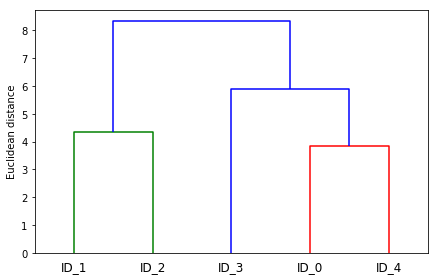

In [15]:
from scipy.cluster.hierarchy import dendrogram

row_dendr = dendrogram(row_clusters, labels=labels)
plt.tight_layout()
plt.ylabel('Euclidean distance')
plt.show()

Such as dendrogram summarizes the different clusters that were formed during the agglomerative hierarchical clustering; for example, we can see that the samples *ID_0* and *ID_4*, followed by *ID_1* and *ID_2*, are the most similar ones based on the Euclidean distance metric.

## Attaching dendrograms to a heat map

In practical application, hierarchical clustering algorithms are often used in combination with a **heat map**, which allows us to represent the individual values in the sample matrix with a color code. In this section, we will discuss how to attach a dendrogram to a heat map plot and order the rows in the heat map correspondingly. 

However, attaching a dendrogram to a heat map can be a little bit trickly, so let's go through this procedure step by step: 

1. We create a new *figure* object and define the *x* axis position, *y* axis position, width, and height of the dendrogram via the *add_axes* attribute. Furthermore, we rotate the dendrogram 90 degrees counter-clockwise.
2. Next, we reorder the data in our initial *DataFrame* according to the clustering labels that can be accessed from the dendrogram object, which is essentially a Python dictionary, via the *leaves* key.
3. Now, we construct the heat map from the reordered *DataFrame* and position it next to the dendrogram. 
4. Finally, we will modify the aesthetics of the dendrogram by removing the axis ticks and hiding the axis spines. Also, we will add a color bar and assign the feature and sample names to the *x* and *y* axis tick labels, respectively. 

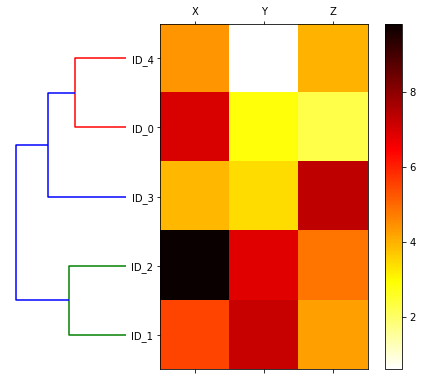

In [16]:
fig = plt.figure(figsize=(8, 8), facecolor='white')
axd = fig.add_axes([0.09, 0.1, 0.2, 0.6])
row_dendr = dendrogram(row_clusters, orientation='left')

df_rowclust = df.iloc[row_dendr['leaves'][::-1]]

axm = fig.add_axes([0.23, 0.1, 0.6, 0.6])
cax = axm.matshow(df_rowclust, interpolation='nearest', 
                  cmap='hot_r')

axd.set_xticks([])
axd.set_yticks([])
for i in axd.spines.values():
    i.set_visible(False)
fig.colorbar(cax)
axm.set_xticklabels([''] + list(df_rowclust.columns))
axm.set_yticklabels([''] + list(df_rowclust.index))
plt.show()

As we can see, the order of the rows in the heat map reflects the clustering of the samples in the dendrogram. In addition to a simple dendrogram, the color-coded values of each sample and feature in the heat map provide us with a nice summary of the dataset. 

## Applying agglomerative clustering via scikit-learning 

In the previous subsection, we saw how to perform agglomerative hierarchical clustering using SciPy. However, there is also an *AgglomerativeClustering* implementation in scikit-learn, which allows us to choose the number of clusters that we want to return. This is useful if we want to prune the hierarchical cluster tree. By setting the *n_cluster* parameter to 3, we will now cluster the samples into three groups using the same complete linkage approach based on the Euclidean distance metric, as before:

In [17]:
from sklearn.cluster import AgglomerativeClustering

ac = AgglomerativeClustering(n_clusters=3, 
                             affinity='euclidean', 
                             linkage='complete')
labels = ac.fit_predict(X)
print('Cluster labels: %s' % labels)

Cluster labels: [1 0 0 2 1]


Looking at the predicted cluster labels, we can see that the first and fifth sample (*ID_0* and *ID_4*) were assigned to one cluster (label 1), and the samples *ID_1* and *ID_2* were assigned to a second cluster (label 0). The sample *ID_3* was put into its own cluster (label 2). Overall, the results are consistent with the results that we observed in the dendrogram. We shall note though that *ID_3* is more similar to *ID_4* and *ID_0* than to *ID_1* and *ID_2*, as shown in the preceding dendrogram figure; this is not clear from scikit-learn's clustering results. Let's now rerun the *AgglomerativeClustering* using *n_clusters=2* in the following code snippet:

In [18]:
ac = AgglomerativeClustering(n_clusters=2, 
                             affinity='euclidean', 
                             linkage='complete')
labels = ac.fit_predict(X)
print('Cluster labels: %s' % labels)

Cluster labels: [0 1 1 0 0]


As we can see, in this *pruned* clustering hierarchy, label *ID_3* was not assigned to the same cluster as *ID_0* and *ID_4*, as expected. 

# Locating regions of high density via DBSCAN

Although we cannot cover the vast amount of different clustering algorithms in this chapter, let's at least introduce one more approach to clustering: **Density-based Spatial Clustering of Applications with Noise (DBSCAN)**, which does not make assumptions about spherical clusters like k-means, nor does it partition the dataset into hierarchies that require a manual cut-off point. As it name implies, density-based clustering assigns clusters labels based on dense regions of points. In DBSCAN, the notion of density is defined as the number of points within a specified radius $\epsilon$. 

According to the DBSCAN algorithm, a special label is assigned to each sample (point) using the following criteria: 

* A point is considered a **core point** if at least a specified number (MinPts) of neighboring poits fall within the specified radius $\epsilon$. 
* A **border point** is a point that has fewer neighbors than MinPts within $\epsilon$, but lies within the $\epsilon$ radius of a core point.
* All other points that are neither core nor border points are considered **noise points**. 

After labeling the points as core, border, or noise, the DBSCAN algorithm can be summarized in two simple steps: 

1. Form a separate cluster for each core point or connected group of core points (core points are connected if they are no farther away than $\epsilon$). 
2. Assign each border point to the cluster of its corresponding core point. 

To get a better understanding of what the result of DBSCAN can look like before jumping to the implementation, let's summarize what we have just learned about core points, border points, and noise points in the following figure:

<img src='images/11_13.png'>

One of the main advantages of using DBSCAN is that it does not assume that the clusters have a spherical shape as in k-means. Furthermore, DBSCAN is different from k-means and hierarchical clustering in that it does not necessarily assign each point to a cluster but is capable of removing noise points. 

For a more illustrative example, let's create a new dataset of half-moon-shaped structures to compare k-means clustering, hierarchical clustering, and DBSCAN: 

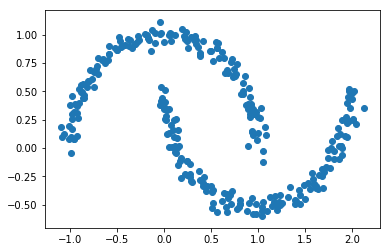

In [20]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=300, noise=0.05, random_state=0)
plt.scatter(X[:, 0], X[:, 1])
plt.show()

As we can see in the resulting plot, there are two visible, half-moon-shaped groups consisting of 100 sample points each. 

We will start by using the k-means algorithm and complete linkage clustering to see if one of those previously discussed clustering algorithms can successfully identify the half-moon shapes as separate clusters. The code is as follows:

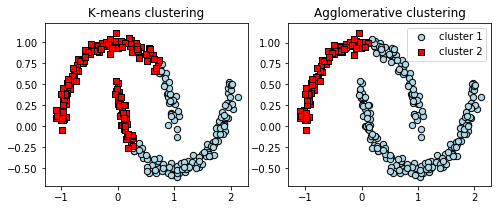

In [22]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

km = KMeans(n_clusters=2, random_state=0)
y_km = km.fit_predict(X)
ax1.scatter(X[y_km==0, 0], X[y_km==0, 1], 
            c='lightblue', edgecolor='black', 
            marker='o', s=40, label='cluster 1')
ax1.scatter(X[y_km==1, 0], X[y_km==1, 1], 
            c='red', edgecolor='black', 
            marker='s', s=40, label='cluster 2')
ax1.set_title('K-means clustering')

ac = AgglomerativeClustering(n_clusters=2, 
                             affinity='euclidean', 
                             linkage='complete')
y_ac = ac.fit_predict(X)
ax2.scatter(X[y_ac==0, 0], X[y_ac==0, 1], 
            c='lightblue', edgecolor='black', 
            marker='o', s=40, label='cluster 1')
ax2.scatter(X[y_ac==1, 0], X[y_ac==1, 1], 
            c='red', edgecolor='black', 
            marker='s', s=40, label='cluster 2')
ax2.set_title('Agglomerative clustering')

plt.legend()
plt.show()

Based on the visualized clustering results, we can see that the k-means algorithm is unable to separate the two cluster, and also the hierarchical clustering algorithm was challenged by those complex shapes. 

Finally, let us try the DBSCAN algorithm on this dataset to see if it can find the two half-moon-shaped clusters using a density-based approach:

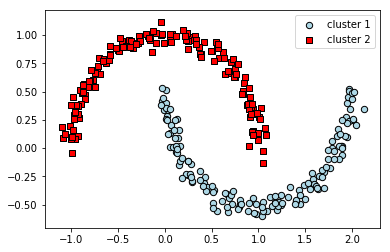

In [25]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.2, min_samples=5, metric='euclidean')
y_db = db.fit_predict(X)
plt.scatter(X[y_db==0, 0], X[y_db==0, 1], 
            c='lightblue', edgecolor='black', 
            marker='o', s=40, label='cluster 1')
plt.scatter(X[y_db==1, 0], X[y_db==1, 1], 
            c='red', edgecolor='black', 
            marker='s', s=40, label='cluster 2')
plt.legend()
plt.show()

The DBSCAN algorithm can successfully detect the half-moon shapes, which highlights one of the strengths of DBSCAN: clustering data of arbitrary shapes.

However, we shall also note some of the disadvantages of DBSCAN. With an increasing number of features in our dataset - assuming a fixed number of training examples - the negative effect of the **curse of dimensionality** increases. This is specially a problem if we are using the Euclidean distance metric. However, the problem of the *curse of dimensionality* is not unique to DBSCAN; it also affects other clustering algorithms that use the Euclidean distance metric, for example, k-means and hierarchical clustering algorithms. In addition, we have two hyperparameters in DBSCAN (MinPts and $\epsilon$) that need to be optimized to yield good clustering results. Findind a good combination of MinPts and $\epsilon$ can be problematic if the density differences in the dataset are relatively large. 

So far, we have seen three of the most fundamental categories of clustering algorithms: prototype-based clustering with k-means, agglomerative hierarchical clustering, and density-based clustering via DBSCAN. However, I also want to mention a fourth class of more advanced clustering algorithms that we have not covered in this chapter: **graph-based clustering**. Probably, the most proeminent member of the graph-based clustering family is the **spectral clustering** algorithms. Although there are many different implementations of spectral clustering, they all have in common that they use the eigenvectors of a similarity or distance matrix to derive the cluster relationships. 

Note that, in practice, it is not always obvious which clustering will perform best on a given dataset, especially if the data comes in multiple dimensions that make it hard or impossible to visualize. Furthermore, it is important to emphasize that a successful clustering not only depends on the algorithm and its hyperparameters. Rather, the choice of an appropriate distance metric and the use of domain knowledge that can help guide the experimental setup can be even more important. 

In the context of the curse of dimensionality, it is thus common practice to apply dimensionality reduction techniques prior to performing clustering. Such dimensionality reduction techniques for unsupervised datasets include principal component analysis and RBF kernel principal component analysis, which we covered in a previous chapter. Also, it is particularly common to compress dataset down to two-dimensional subspaces, which allows us to visualize the clusters and assigned labels using two-dimensional scatterplots, which are particularly helpful for evaluating the results. 

# Summary

In this chapter, you learned about three different clustering algorithms that can help us with the discovery of hidden structures or information in data. We started this chapter with a prototype-based approach, k-means, which clusters samples into spherical shapes based on a specified number of cluster centroids. Since clustering is an unsupervised method, we do not enjoy the luxury of ground truth labels to evaluate the performance of the model. Thus, we used intrinsic performance metrics such as the elbow method or silhouette analysis as an attempt to quantify the quality of clustering. 

We then looked at a different approach to clustering: agglomerative hierarchical clustering. Hierarchical clustering does not require specifying the number of clusters up front, and the result can be visualized in a dendrogram representation, which can help with the interpretation of the results. The last clustering algorithm that we saw in this chapter was DBSCAN, an algorithm that groups points based on local densities and is capable of handling outliers and identifying non-globular shapes. 

After this excursion into the field of unsupervised learning, it is now about time to introduce some of the most exciting machine learning algorithms for supervised learning: multilayer artificial neural networks. After their recent resurgence, neural networks are once again the hottest topic in machine learning research. Thanks to recently developed deep learning algorithms, neural networks are considered state-of-art for many complex tasks such as image classification and speech recognition. In the nexts two chapters, we will construct our own multilayer neural network from scratch and introduce powerful libraries that can help us to train complex network architectures most efficiently. 